$$u_{t}-\Delta u = 10$$ for $$(t,x,y) \in (0,1) \times \Omega \subset \mathbb{R}^{2}$$ and $u = 0$ on $(0,1) \times \partial \Omega.$ 


Where:

$$\Omega = (-1,1)^2 \setminus (0,1) \times (-1,0)$$ in a "L"-shape domain with coordinates and elements as shown in the picture below:

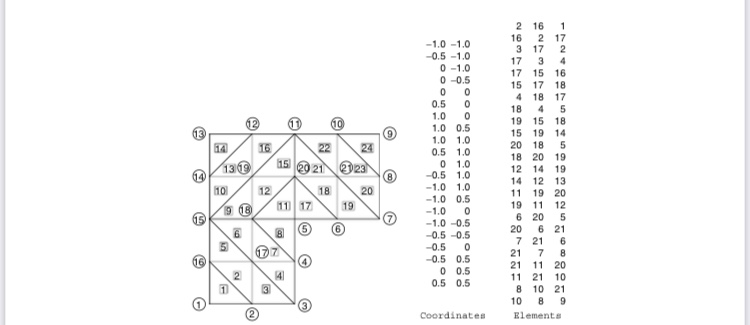

In [1]:
from IPython.display import Image
Image(filename ="/Users/nikosmatsavelas/Desktop/IMG_8369.jpg")

In [2]:
import dmsh
import numpy as np
from skfem import *
from skfem.models.poisson import laplace, unit_load
from skfem import LinearForm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 18})

## Coordinate array 

In [3]:
coordinates = np.array([
        [-1.0, -1.0],
        [-0.5, -1.0],
        [ 0.0, -1.0],
        [ 0.0, -0.5],
        [ 0.0,  0.0],
        [ 0.5,  0.0],
        [ 1.0,  0.0],
        [ 1.0,  0.5],
        [ 1.0,  1.0],
        [ 0.5,  1.0],
        [ 0.0,  1.0],
        [-0.5,  1.0],
        [-1.0,  1.0],
        [-1.0,  0.5],
        [-1.0,  0.0],
        [-1.0, -0.5],
        [-0.5, -0.5],
        [-0.5,  0.0],
        [-0.5,  0.5],
        [ 0.0,  0.5],
        [ 0.5,  0.5]]);print(coordinates)




[[-1.  -1. ]
 [-0.5 -1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.5  0. ]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]
 [ 0.5  1. ]
 [ 0.   1. ]
 [-0.5  1. ]
 [-1.   1. ]
 [-1.   0.5]
 [-1.   0. ]
 [-1.  -0.5]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [ 0.   0.5]
 [ 0.5  0.5]]


## Element array 

In [4]:
elements = np.array([[2,  16, 1], 
                     [16,  2,17],
                     [3,  17, 2],
                     [17,  3, 4],
                     [17, 15,16],
                     [15, 17,18],
                     [4,  18,17],
                     [18,  4, 5],
                     [19, 15,18], 
                     [15, 19,14],
                     [20, 18, 5],
                     [18, 20,19],
                     [12, 14,19], 
                     [14, 12,13],
                     [11, 19,20],
                     [19, 11,12],
                     [6,  20, 5],
                     [20,  6,21],
                     [7,  21, 6],
                     [21,  7, 8],
                     [21, 11,20],
                     [11, 21,10],
                     [8,  10,21],
                     [10,  8, 9]]);print(elements)

[[ 2 16  1]
 [16  2 17]
 [ 3 17  2]
 [17  3  4]
 [17 15 16]
 [15 17 18]
 [ 4 18 17]
 [18  4  5]
 [19 15 18]
 [15 19 14]
 [20 18  5]
 [18 20 19]
 [12 14 19]
 [14 12 13]
 [11 19 20]
 [19 11 12]
 [ 6 20  5]
 [20  6 21]
 [ 7 21  6]
 [21  7  8]
 [21 11 20]
 [11 21 10]
 [ 8 10 21]
 [10  8  9]]


## Crank Nicolson 

For Cn method we dicretise time in a symmetric way around $t_{n-1/2}$ 

***Weak form***


$$(u_{t},\phi)+a(u,\phi)=(f,\phi)$$
$\forall v \in \mathcal{H}_{0}^{1}(w)$ and $t>0$
$$ a(v,w)=\int_{\Omega} \nabla u \cdot \nabla w dx$$
$$(v,w) = \int_{\Omega} v w dx$$

We want to find $V_{\eta}(t)=V_{\eta}(\cdot,t) \in V_{\eta}$
So we have : 
$$ V_{\eta}(t,x)+a(V_{\eta},x)=f,x $$ $\forall x \in V_{\eta},t>0$


$$ \left( \frac{U^{n}-U^{n-1}}{t},x\right)+ a\left(U^{n},x \right) = f\left( t_{n},x\right)$$

Multiply both sides with $t$ we get: 

$$\left( U^{n}-U^{n-1},x\right) + t a (U^{n},x)=t f\left( t_{n},x\right)$$

Rearranging : 




\begin{align*}
(U^{n},x)+t a(U^{n},x)=&U^{n-1}+t f\left( t_{n},x\right) \\
\left( \frac{U^{n}-U^{n-1}}{t},x \right) +a \left(\frac{1}{2} (U^{n}+U^{n-1}),x\right) =&  f(t_{n-1/2},x)\\
  (U^{n}-U^{n-1},x)+t a (\frac{1}{2}(U^{n}+U^{n-1}),x ) =& t f(t_{n-1/2},x)\\
U^{n}-U^{n-1} +t a \frac{1}{2}(U^{n}+U^{n-1}) =& t f(t_{n-1/2})\\
U^{n}+t a \frac{1}{2}(U^{n}+U^{n-1})=&U^{n-1}+t f(t_{n-1/2}) \\
U^{n}+ t a \frac{1}{2}U^{n}+t a \frac{1}{2}U^{n-1}=&U^{n-1}+t f(t_{n-1/2})\\
U^{n}+t a \frac{1}{2}U^{n} =& -t a \frac{1}{2}U^{n-1}+U^{n-1}+t f(t_{n-1/2})
\end{align*}

In matrix notation $$Ba^{n}+\frac{1}{2}t Aa^{n}=Ba^{n-1}-\frac{1}{2}t Aa^{n-1}+tb^{n-1/2}$$ for $n \geq 1$

Where $B$ = mass matrix ,
$A=$ stiff matrix

dt = 0.01 µs


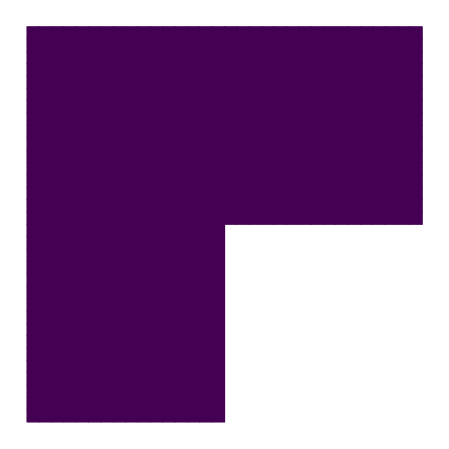

In [21]:
import numpy as np
from skfem import *
from skfem.models.poisson import laplace, unit_load,mass
from skfem import LinearForm
from typing import Iterator, Tuple
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import splu





@LinearForm
def loading(v, w):
    return(10 * w.x[0] * v)

m = MeshTri(coordinates.T, elements.T - 1)
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)





ncells = 2**3
diffusivity = 1.


L = diffusivity * asm(laplace, basis)
M = asm(mass, basis)

dt = .01
print(f'dt = {dt} µs')
theta = 0.5                     # Crank–Nicolson
A = M + theta * L * dt
B = M - (1 - theta) * L * dt


u_init = np.zeros(basis.N) 
boundary = basis.find_dofs()
interior = basis.complement_dofs(boundary)


s = asm(loading, basis)


def step(t: float, u: np.ndarray) -> Tuple[float, np.ndarray]:
    u_new = np.zeros_like(u)  # zero Dirichlet conditions
    _, b1 = condense(
        csr_matrix(A.shape),  # ignore condensed matrix
        B @ u + s * dt,
        u_new,
        D=boundary,
        expand=False,
    )
    u_new[interior] = backsolve(b1)
    return t + dt, u_new


def evolve(t: float, u: np.ndarray) -> Iterator[Tuple[float, np.ndarray]]:

    while True:
        u_old = u.copy()
        t, u = step(t, u)
        if np.linalg.norm(u - u_old) < 2 ** -3 * dt:
            break
        yield t, u


if __name__ == "__main__":

    from argparse import ArgumentParser
    from pathlib import Path

    from matplotlib.animation import FuncAnimation
    import matplotlib.pyplot as plt

    from skfem.visuals.matplotlib import plot

    
   

    ax = plot(m, u_init, shading="gouraud")
    
    def update(event):
        t, u = event

        u0 = {"skfem": basis.interpolator(u)(np.zeros((2, 1)))[0]}
        print("{:4.2f}, {:5.3f}".format(t, u0["skfem"]))

        
    
        plt.show()